### Import packages

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import glob
import cv2
import random
import seaborn as sns
from collections import Counter

### Load and Explore the Data

In [2]:
tumor_paths = list(glob.iglob("./dataset/Tumor/*"))
healthy_paths = list(glob.iglob("./dataset/No Tumor/*"))

print(f"Found {len(tumor_paths)} tumor images and {len(healthy_paths)} healthy images")

Found 155 tumor images and 98 healthy images


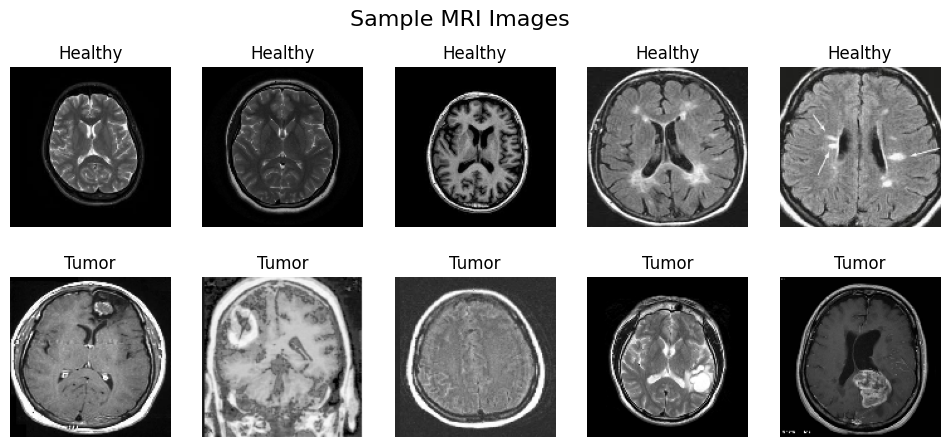

In [3]:
def load_images(paths, num=5):
    imgs = []
    for f in random.sample(paths, min(num, len(paths))):
        img = cv2.imread(f)
        img = cv2.cvtColor(cv2.resize(img, (128, 128)), cv2.COLOR_BGR2RGB)
        imgs.append(img)
    return imgs

tumor_samples = load_images(tumor_paths)
healthy_samples = load_images(healthy_paths)


plt.figure(figsize=(12, 5))
for i, img in enumerate(healthy_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title("Healthy")
    plt.axis("off")

for i, img in enumerate(tumor_samples):
    plt.subplot(2, 5, 5 + i + 1)
    plt.imshow(img)
    plt.title("Tumor")
    plt.axis("off")

plt.suptitle("Sample MRI Images", fontsize=16)
plt.show()


#### class distribution

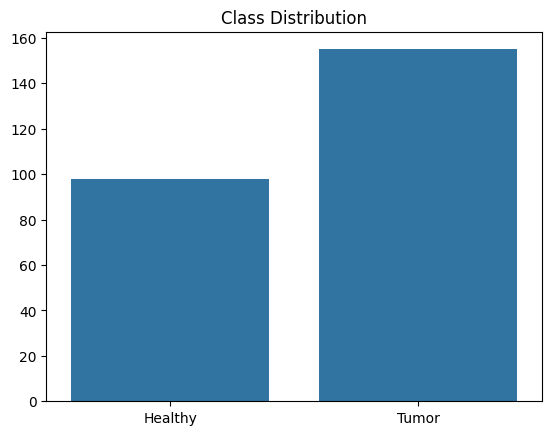

In [4]:
sns.barplot(x=['Healthy', 'Tumor'], y=[len(healthy_paths), len(tumor_paths)])
plt.title("Class Distribution")
plt.show()

#### Checking for corrupted or blank images

In [5]:
def check_corrupted(paths):
    corrupted = []
    for f in paths:
        img = cv2.imread(f)
        if img is None or img.size == 0:
            corrupted.append(f)
    return corrupted

corrupted_tumor = check_corrupted(tumor_paths)
corrupted_healthy = check_corrupted(healthy_paths)

print(f"❌ Corrupted tumor images: {len(corrupted_tumor)}")
print(f"❌ Corrupted healthy images: {len(corrupted_healthy)}")

if corrupted_tumor or corrupted_healthy:
    print("List of corrupted files:")
    print(corrupted_tumor + corrupted_healthy)


❌ Corrupted tumor images: 0
❌ Corrupted healthy images: 0


### Define data augmentation transforms

In [6]:
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
    transforms.RandomVerticalFlip(p=0.3),   # add vertical flips if biologically valid
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # slight blur

])

# Validation/Test transforms
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

### Create custom Dataset class

In [7]:
class MRIDataset(Dataset):
    def __init__(self, image_paths_tumor, image_paths_healthy, transform=None):
        self.images = []
        self.labels = []
        self.transform = transform

        # Load tumor images (label = 1)
        for f in image_paths_tumor:
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            self.images.append(img)
            self.labels.append(1.0)

        # Load healthy images (label = 0)
        for f in image_paths_healthy:
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            self.images.append(img)
            self.labels.append(0.0)

        # Shuffle
        indices = np.arange(len(self.images))
        np.random.shuffle(indices)
        self.images = np.array(self.images, dtype=np.uint8)[indices]
        self.labels = np.array(self.labels, dtype=np.float32)[indices]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
        return {'image': image, 'label': label}



### Split Train / Test Sets

In [8]:
split_ratio = 0.8
tumor_split = int(split_ratio * len(tumor_paths))
healthy_split = int(split_ratio * len(healthy_paths))

train_tumor = tumor_paths[:tumor_split]
test_tumor = tumor_paths[tumor_split:]
train_healthy = healthy_paths[:healthy_split]
test_healthy = healthy_paths[healthy_split:]

train_dataset = MRIDataset(train_tumor, train_healthy, transform=transform_train)
test_dataset = MRIDataset(test_tumor, test_healthy, transform=transform_test)


In [9]:
# Count class occurrences
labels_list = train_dataset.labels
class_counts = Counter(labels_list)
print("Class distribution in training set:", class_counts)

# Calculate class weights (inverse frequency)
class_weights = 1. / torch.tensor([class_counts[0.0], class_counts[1.0]])
sample_weights = [class_weights[int(label)] for label in labels_list]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


Class distribution in training set: Counter({1.0: 124, 0.0: 78})


In [10]:
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Training samples: {len(train_dataset)} | Testing samples: {len(test_dataset)}")


Training samples: 202 | Testing samples: 51


### Visualize Augmented Images

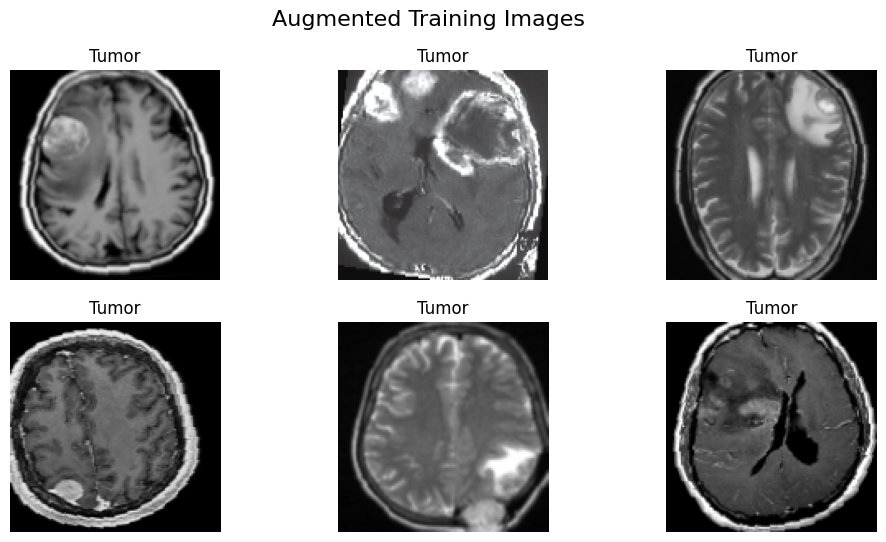

In [11]:
names = {0: 'Healthy', 1: 'Tumor'}

sample_batch = next(iter(train_loader))
images, labels = sample_batch['image'], sample_batch['label']

plt.figure(figsize=(12, 6))
for i in range(6):
    img = images[i].permute(1, 2, 0)  # (C,H,W) → (H,W,C)
    img = (img * 0.5 + 0.5).clamp(0, 1)  # Unnormalize for display
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(names[int(labels[i].item())])
    plt.axis('off')
plt.suptitle("Augmented Training Images", fontsize=16)
plt.show()

### CNN Model Definition

In [12]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [13]:
# Fix random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")


✅ Using device: cuda


### CNN Architecture

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # --- Convolutional feature extractor ---
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # --- Fully connected classifier ---
        self.fc_model = nn.Sequential(
            nn.Linear(64 * 32 * 32, 256),  # (128x128 input → 32x32 feature maps after pooling)
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc_model(x)
        return x  # no sigmoid here — we'll apply it in loss or eval phase



### Initialize Model, Loss, Optimizer

In [15]:
# Initialize model
model = CNN().to(device)

# Compute class counts
neg = class_counts[0.0]  # Healthy
pos = class_counts[1.0]  # Tumor

# ✅ If the tumor class is underrepresented, increase its relative weight
# BCEWithLogitsLoss expects pos_weight = weight for the positive class
# So use neg / pos  (NOT pos / neg)
pos_weight = torch.tensor([neg / pos]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizer and scheduler
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

print(f"Using pos_weight = {pos_weight.item():.3f}")


Using pos_weight = 0.629


### Training Loop

In [16]:
num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # ----- TRAINING -----
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for batch in train_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device).view(-1, 1)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (torch.sigmoid(outputs) >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # ----- VALIDATION -----
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for batch in test_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device).view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            
            predicted = (torch.sigmoid(outputs) >= 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(test_loader)
    val_acc = 100 * val_correct / val_total

    # Track metrics
    scheduler.step()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]"
          f" | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}"
          f" | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")



Epoch [1/20] | Train Loss: 0.5924 | Val Loss: 0.5206 | Train Acc: 54.95% | Val Acc: 45.10%
Epoch [2/20] | Train Loss: 0.4853 | Val Loss: 0.5579 | Train Acc: 61.39% | Val Acc: 64.71%
Epoch [3/20] | Train Loss: 0.5210 | Val Loss: 0.5572 | Train Acc: 63.86% | Val Acc: 70.59%
Epoch [4/20] | Train Loss: 0.4824 | Val Loss: 0.6155 | Train Acc: 70.30% | Val Acc: 43.14%
Epoch [5/20] | Train Loss: 0.4690 | Val Loss: 0.5160 | Train Acc: 66.83% | Val Acc: 72.55%
Epoch [6/20] | Train Loss: 0.4461 | Val Loss: 0.5183 | Train Acc: 66.83% | Val Acc: 70.59%
Epoch [7/20] | Train Loss: 0.4261 | Val Loss: 0.6545 | Train Acc: 71.29% | Val Acc: 50.98%
Epoch [8/20] | Train Loss: 0.4266 | Val Loss: 0.5545 | Train Acc: 68.32% | Val Acc: 68.63%
Epoch [9/20] | Train Loss: 0.4170 | Val Loss: 0.6253 | Train Acc: 70.30% | Val Acc: 54.90%
Epoch [10/20] | Train Loss: 0.3960 | Val Loss: 0.6332 | Train Acc: 74.26% | Val Acc: 74.51%
Epoch [11/20] | Train Loss: 0.4086 | Val Loss: 0.6189 | Train Acc: 75.25% | Val Acc: 74.5

Plot Training Progress

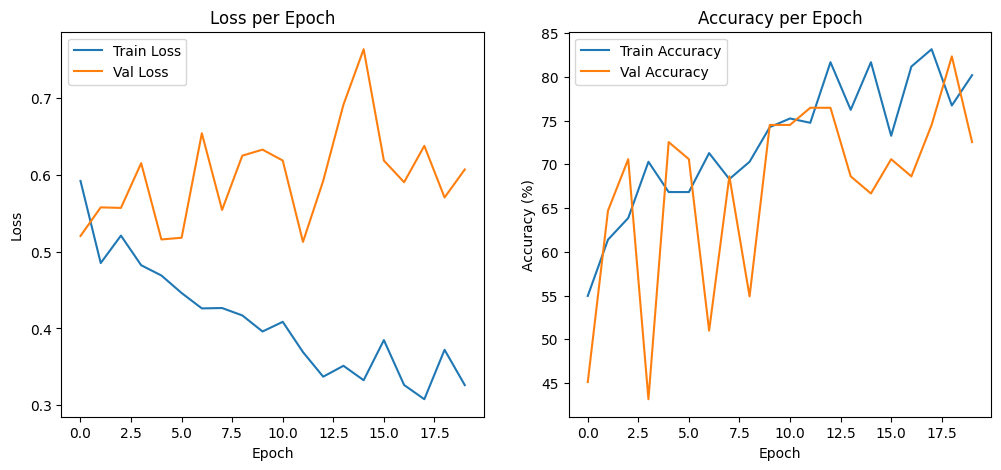

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()


### Evaluate on Test Set

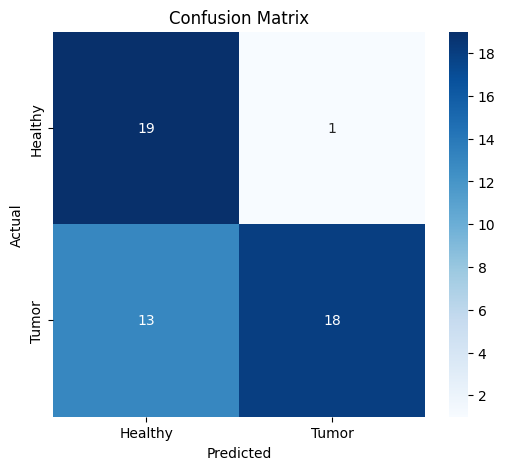


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.59      0.95      0.73        20
       Tumor       0.95      0.58      0.72        31

    accuracy                           0.73        51
   macro avg       0.77      0.77      0.73        51
weighted avg       0.81      0.73      0.72        51



In [18]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device).view(-1, 1)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        predicted = (probs >= 0.5).float()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred).flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Healthy', 'Tumor'],
            yticklabels=['Healthy', 'Tumor'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Tumor']))



### Visualize Predictions

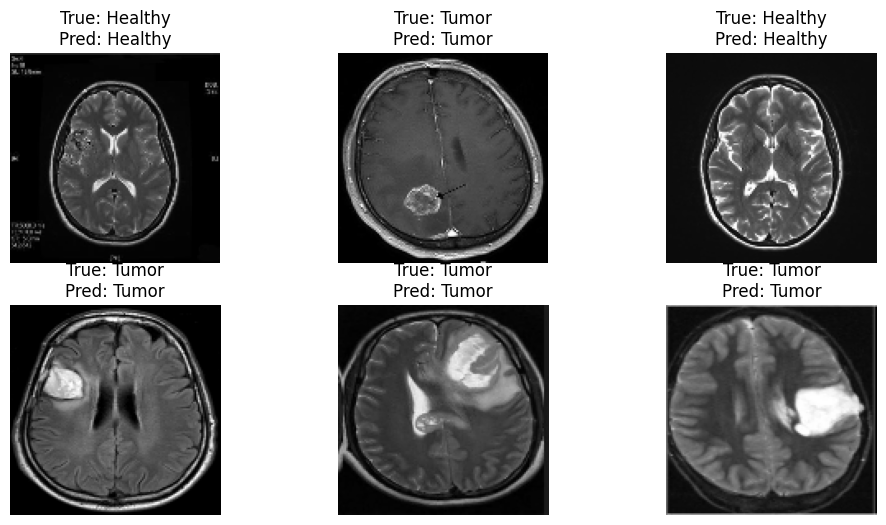

In [19]:
names = {0: 'Healthy', 1: 'Tumor'}
sample_batch = next(iter(test_loader))
images = sample_batch['image'].to(device)
labels = sample_batch['label'].to(device).view(-1, 1)
outputs = model(images)
predicted = (torch.sigmoid(outputs) >= 0.5).float()

plt.figure(figsize=(12,6))
for i in range(6):
    img = images[i].cpu().permute(1,2,0)
    img = (img * 0.5) + 0.5  # unnormalize
    true_label = int(labels[i].item())
    pred_label = int(predicted[i].item())
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f"True: {names[true_label]}\nPred: {names[pred_label]}")
    plt.axis('off')
plt.show()

In [20]:
torch.save(model.state_dict(), "cnn_brain_tumor_model.pth")
